# Multiple Discretization

This tutorial shows how to compute recurrence coefficients for non-trivial weight functions, and how they are being used for quadrature.
The method we use is called *multiple discretization*, and follows W. Gautschi's book "Orthogonal Polynomials: Computation and Approximation", specifically Section 2.2.4, and Example 2.38.

Suppose we have the weight function
$$
\forall t \in [-1,1], \gamma \in [0,1]: \quad w(t;\gamma) = \gamma + (1-\gamma) \frac{1}{\sqrt{1-t^2}},
$$
and we would like to solve
$$
\int_{-1}^{1} f(t) w(t;c) \mathrm{d}t = \sum_{\nu=1}^{N} f(\tau_\nu) w_\nu
$$
by some quadrature rule.
We will see that ad-hoc quadrature rules will fail to solve the integral even for the simplest choice $f \equiv 1$.
However, finding the recurrence coefficients of the underlying orthogonal polynomials, and then finding the quadrature rule will be the way to go.

Let us first try to solve the integral for $f \equiv 1$ by Fejer's rule.

In [2]:
using PolyChaos, LinearAlgebra
γ = 0.5;
int_exact = 1+pi/2; # exact value of the integral
function my_w(t::Float64,γ::Float64)
    γ + (1-γ)*1/sqrt(1-t^2)
end

N = 1000;
n,w = fejer(N);
int_fejer = dot(w,my_w.(n,γ))
print("Fejer error:\t$(abs(int_exact-int_fejer))\twith $N nodes")

Fejer error:	0.00034489625618583375	with 1000 nodes

Clearly, that is not satisfying.
Well, the term $\gamma$ of the weight $w$ makes us think of Gauss-Legendre integration, so let's try it instead.

In [3]:
function quad_gaussleg(N::Int,γ::Float64)
    a,b=rm_legendre(N)
    n,w=golubwelsch(a,b)
end
n,w = quad_gaussleg(N,γ)
int_gaussleg = dot(w,γ .+ (1-γ)/sqrt.(1 .- n.^2))
print("Gauss-Legendre error:\t$(abs(int_exact-int_gaussleg))\twith $N nodes")

Gauss-Legendre error:	1.569226315865443	with 1000 nodes

Even worse!
Well, we can factor out $\frac{1}{\sqrt{1-t^2}}$, making the integral amenable to a Gauss-Chebyshev rule.
So, let's give it anothery try.

In [4]:
function quad_gausscheb(N::Int64,γ::Float64)
    a,b = rm_chebyshev1(N)
    n,w = golubwelsch(a,b)
end
n,w = quad_gausscheb(N,γ)
int_gausscheb = dot(w,γ .+ (1-γ)*sqrt.(1 .- n.^2))
# int=sum(xw(:,2).*(1+sqrt(1-xw(:,1).^2)))
print("Gauss-Chebyshev error:\t$(abs(int_exact-int_gausscheb))\twith $N nodes")

Gauss-Chebyshev error:	4.112336209338707e-7	with 1000 nodes

Okay, that's better, but it took us a lot of nodes to get this result.
Is there a different way?
Indeed, there is.
As we have noticed, the weight $w$ has a lot in common with Gauss-Legendre *and* Gauss-Chebyshev.
We can decompose the integral as follows
$$
\int_{-1}^1 f(t) w(t) \mathrm{d}t = \sum_{i=1}^{m} \int_{-1}^{1} f(t) w_i(t) \mathrm{d} t,
$$
with
$$
\begin{align*}
w_1(t) &= \gamma \\
w_2(t) &= (1-\gamma) \frac{1}{\sqrt{1-t^2}}.
\end{align*}
$$
To the weight $w_1$ we can apply Gauss-Legendre quadrature, to the weight $w_2$ we can apply Gauss-Chebyshev quadrature (with tiny modifications).
This *discretization* of the measure can be used in our favor.
The function `mcdiscretization()` takes the $m$ discretization rules as an input

In [5]:
function quad_gaussleg_mod(N::Int,γ::Float64)
    n,w = quad_gaussleg(N,γ)
    return n,γ*w
end
function quad_gausscheb_mod(N::Int,γ::Float64)
            n,w = quad_gausscheb(N,γ)
    return n,(1-γ)*w
end

N = 8
a,b = mcdiscretization(N,[n->quad_gaussleg_mod(n,γ); n->quad_gausscheb_mod(n,γ)])
n,w = golubwelsch(a,b)
int_mc = sum(w)
print("Discretization error:\t$(abs(int_exact-int_mc))\twith $N nodes")

Discretization error:	5.773159728050814e-15	with 8 nodes

Et voilà, no error with fewer nodes.
(For this example, we'd need in fact just a single node.)

The function `mcdiscretization()` is able to construct the recurrence coefficients of the orthogonal polynomials relative to the weight $w$.
Let's inspect the values of the recurrence coefficients a little more.
For $\gamma = 0$, we are in the world of Chebyshev polynomials, for $\gamma = 1$, we enter the realm of Legendre polynomials. And in between?
That's exactly where the weight $w$ comes in: it can be thought of as an interpolatory weight, interpolating Legendre polynomials and Chebyshev polynomials.
Let's verify this by plotting the recurrence coefficients for several values of $\gamma$.



In [6]:
Γ = 0:0.1:1;
ab = [ mcdiscretization(N,[n->quad_gaussleg_mod(n,gam); n->quad_gausscheb_mod(n,gam)]) for gam in Γ ];
bb = hcat([ ab[i][2] for i=1:length(Γ)]...);
b_leg = rm_legendre(N)[2];
b_cheb = rm_chebyshev1(N)[2]
bb[:,1]-b_cheb

8-element Array{Float64,1}:
  1.2434497875801753e-14
  3.1086244689504383e-15
 -7.494005416219807e-16 
  5.551115123125783e-16 
  1.0547118733938987e-15
  4.440892098500626e-16 
 -1.3877787807814457e-15
  6.661338147750939e-16 

In [7]:
bb[:,end]-b_leg

8-element Array{Float64,1}:
 -4.440892098500626e-16 
  3.3306690738754696e-16
 -8.326672684688674e-16 
  4.440892098500626e-16 
  7.771561172376096e-16 
  2.220446049250313e-16 
 -9.992007221626409e-16 
  9.43689570931383e-16  

Let's plot these values to get a better feeling.

┌ Warning: The default `strides(a::AbstractArray)` implementation is deprecated for general arrays.
│ Specialize `strides(::Adjoint)` if `Adjoint` indeed uses a strided representation in memory.
│ Warning: inappropriately implementing this method for an array type that does not use strided
│ storage may lead to incorrect results or segfaults.
│   caller = stride at abstractarray.jl:350 [inlined]
└ @ Core ./abstractarray.jl:350
┌ Warning: The default `strides(a::AbstractArray)` implementation is deprecated for general arrays.
│ Specialize `strides(::Adjoint)` if `Adjoint` indeed uses a strided representation in memory.
│ Warning: inappropriately implementing this method for an array type that does not use strided
│ storage may lead to incorrect results or segfaults.
│   caller = ip:0x0
└ @ Core :-1


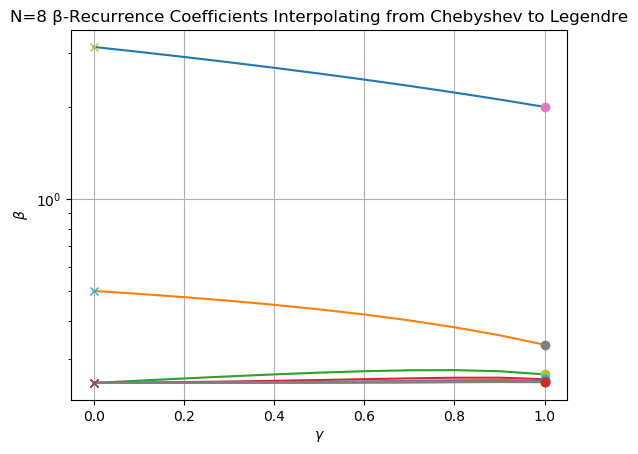

In [8]:
using PyPlot
figure(1);
grid(true);
semilogy(Γ,bb');
[ plot(0.,b_cheb[i],"x") for i=1:N ];
[ plot(1.,b_leg[i],"o") for i=1:N ];
ttl = latexstring("N=$N  Recurrence Coefficients Interpolating from Chebyshev to Legendre");
xlabel(L"\gamma");
ylabel(L"\beta");
title("N=$N β-Recurrence Coefficients Interpolating from Chebyshev to Legendre");

The crosses denote the values of the β recursion coefficients for Chebyshev polynomials; the circles the β recursion coefficients for Legendre polynomials.
The interpolating line in between stands for the β recursion coefficients of $w(t;\gamma)$.